In [92]:
import re
import datetime as dt
import logging
from urllib import request
from urllib.error import HTTPError, URLError

import pandas as pd
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import boto3
from botocore.exceptions import ClientError
%matplotlib inline

In [105]:
def upload_file(file_name, bucket, object_name=None, ExtraArgs={'ACL': 'public-read'}):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    print(f'{object_name} added to {bucket}.')
    return True

DAYS = dt.date.today() - dt.date(2020,3,25)
NOW = dt.date.today()
YESTERDAY = dt.date.today() + dt.timedelta(days = -DAYS.days)
MONTHDAYYEAR = "%m-%d-%Y"

county = re.compile(r'^\s?(\w*[\s\w]*)\sCOUNTY.*\((?:state reports?\s?)?(\d+\,\d+|\d+)\s(?:cases?|with).*')
town = re.compile(r'.[\*\s]?([\w\s]*):\s(\d+\,\d+|\d+).*')
deaths = re.compile(
            r'.*\w*:\s?.*(?:with)?\s(\d+\,\d+|\d+)\s(?:death|fatalitie|fatality|who died)s?.*',
            re.IGNORECASE
        )
recovered = re.compile(
            r'.*(\d+\,\d+|\d+)\s(?:cleared from quarantine|who recovered'\
            +r'|have recovered|recovered).*',
            re.IGNORECASE
            )

hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36' +\
           '(KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36' }

towns = []
counties = []

def get_url(day):
    return f"https://www.nj.com/coronavirus/{day.strftime('%Y')}/{day.strftime('%m')}/"+\
        f"where-is-the-coronavirus-in-nj-latest-map-update-on-county-by-county-cases-"+\
        f"{day.strftime('%B').lower()}-{day.strftime('%-d')}-{day.strftime('%Y')}.html"


def open_url(day, hdr, fix_html = False, regex = r'<div class="rawhtml".*\(\);'):
    url = get_url(day)
    if fix_html:
        try:
            req = request.Request(url, headers=hdr)
            html = bs(request.urlopen(url), 'lxml')
            print(f'Date: {day.strftime(MONTHDAYYEAR)} Successfully opened and repaired')
        except HTTPError as e:
            print(f'Date: {day.strftime(MONTHDAYYEAR)}\nError trying to open {url}\n{e}')
            return None
        except URLError as e:
            print(f'Date: {day.strftime(MONTHDAYYEAR)}\nError trying to open {url}\n{e}')
            return None
    else:
        try:
            req = request.Request(url, headers=hdr)
            response = request.urlopen(req)

            html = bs(re.sub(
                        regex,
                        '',
                        response.read().decode('utf-8')),
                      'lxml'
                      )
            print(f'Date: {day.strftime(MONTHDAYYEAR)} Successfully opened')
        except HTTPError as e:
            print(f'Date: {day.strftime(MONTHDAYYEAR)}\nError trying to open {url}\n{e}')
            return None
        except URLError as e:
            print(f'Date: {day.strftime(MONTHDAYYEAR)}\nError trying to open {url}\n{e}')
            return None
    return html


def scraper(day, hdr, fix_html):
    current_html = open_url(day, hdr, fix_html)
    if not current_html:
        return None
    
    current_county = ''
    
    for p in current_html.find_all('p', ['article__paragraph', 'article__paragraph--left']):
        if county.match(p.text):
            current_county = county.match(p.text).group(1).title()
            current_cases = int(county.match(p.text).group(2).replace(',', ''))
            if current_cases > 20000:
                print(p.text)
            counties.append(
                [day.strftime(MONTHDAYYEAR),
                 current_county,
                 current_cases]
                )
        if town.match(p.text):
            town_name = town.match(p.text).group(1)
            town_ct = int(town.match(p.text).group(2).replace(',', ''))
            death_ct = 0
            recovered_ct = 0
            if deaths.match(p.text):
                death_ct = int(deaths.match(p.text).group(1).replace(',', ''))
            if recovered.match(p.text):
                recovered_ct = int(recovered.match(p.text).group(1).replace(',', ''))
            towns.append(
                        [day.strftime(MONTHDAYYEAR),
                         current_county,
                         town_name,
                         town_ct,
                         death_ct,
                         recovered_ct
                        ])
    
    
for delta in range(DAYS.days+1):
    current_day = NOW + dt.timedelta(days=-delta)
    if current_day in [dt.date(2020,3,27), dt.date(2020,3,28), dt.date(2020,4,18)]:
        fix_html = True
    else:
        fix_html = False
    scraper(current_day, hdr, fix_html)

towns = pd.DataFrame(towns,
                     columns=['Date','County', 'City', 'Cases',
                              'Deaths', 'Recoveries']
                    )

counties = pd.DataFrame(counties,
                      columns=['Date', 'County', 'Cases'])

towns.Date = pd.to_datetime(towns.Date)
counties.Date = pd.to_datetime(counties.Date)

print('\nTowns data points: ', towns.shape[0])
print('\nCounties data points: ', counties.shape[0])

Date: 05-08-2020
Error trying to open https://www.nj.com/coronavirus/2020/05/where-is-the-coronavirus-in-nj-latest-map-update-on-county-by-county-cases-may-8-2020.html
HTTP Error 404: Not Found
Date: 05-07-2020 Successfully opened
Date: 05-06-2020 Successfully opened
Date: 05-05-2020 Successfully opened
Date: 05-04-2020 Successfully opened
OCEAN COUNTY (6,6974 with 447 deaths; county reports 6,837 with 430 deaths)
UNION COUNTY (13,2357 with 737 deaths)
Date: 05-03-2020 Successfully opened
Date: 05-02-2020 Successfully opened
Date: 05-01-2020
Error trying to open https://www.nj.com/coronavirus/2020/05/where-is-the-coronavirus-in-nj-latest-map-update-on-county-by-county-cases-may-1-2020.html
HTTP Error 404: Not Found
Date: 04-30-2020 Successfully opened
Date: 04-29-2020
Error trying to open https://www.nj.com/coronavirus/2020/04/where-is-the-coronavirus-in-nj-latest-map-update-on-county-by-county-cases-april-29-2020.html
HTTP Error 404: Not Found
Date: 04-28-2020 Successfully opened
Date

In [106]:
counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 3 columns):
Date      833 non-null datetime64[ns]
County    833 non-null object
Cases     833 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 19.6+ KB


In [107]:
counties.County.unique()

array(['Atlantic', 'Bergen', 'Burlington', 'Camden', 'Cape May',
       'Cumberland', 'Essex', 'Gloucester', 'Hudson', 'Hunterdon',
       'Mercer', 'Middlesex', 'Monmouth', 'Morris', 'Ocean', 'Passaic',
       'Salem', 'Somerset', 'Sussex', 'Union', 'Warren'], dtype=object)

In [108]:
counties[['County','Date']].groupby('County').count()

,Date
County,
Atlantic,23
Bergen,41
Burlington,40
Camden,40
Cape May,41
Cumberland,41
Essex,42
Gloucester,39
Hudson,41


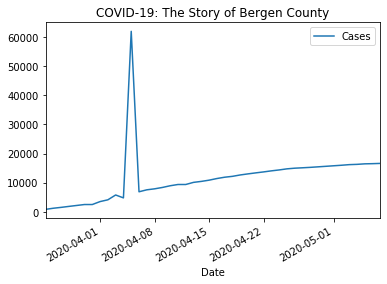

In [112]:
counties[counties.County == 'Bergen'].plot(x='Date',y='Cases', title='COVID-19: The Story of Bergen County')

In [ ]:
cases_w_shared_zips.to_csv(f'{YESTERDAY.strftime(MONTHDAYYEAR)}-complete.csv', index=False)
output[['Zip Code', 'City', 'Cases']].to_csv(f'{YESTERDAY.strftime(MONTHDAYYEAR)}-cases.csv', index=False)
output.drop_duplicates(['City','County'], keep='first').groupby('Zip Code').\
    sum().to_csv(f'{YESTERDAY.strftime(MONTHDAYYEAR)}-zips.csv', index=False)

upload_file(f'{YESTERDAY.strftime(MONTHDAYYEAR)}-complete.csv',
            'athenedyne-covid-19',
           f'Complete/{YESTERDAY.strftime(MONTHDAYYEAR)}-complete.csv')
            
upload_file(f'{YESTERDAY.strftime(MONTHDAYYEAR)}-cases.csv',
           'athenedyne-covid-19',
           f'Cases/{YESTERDAY.strftime(MONTHDAYYEAR)}-cases.csv')

upload_file(f'{YESTERDAY.strftime(MONTHDAYYEAR)}-zips.csv',
           'athenedyne-covid-19',
           f'ZIPs/{YESTERDAY.strftime(MONTHDAYYEAR)}-zips.csv')

In [ ]:
if output[output['Zip Code'].isna()][['Zip Code', 'City', 'County']].shape[0] > 0:
    output[output['Zip Code'].isna()][['Zip Code', 'City', 'County']].\
        to_csv(f'{YESTERDAY.strftime(MONTHDAYYEAR)}-missing-ZIPs.csv',
              index=False)
    upload_file(f'{YESTERDAY.strftime(MONTHDAYYEAR)}-missing-ZIPs.csv',
               'athenedyne-covid-19',
               f'{YESTERDAY.strftime(MONTHDAYYEAR)}-missing-ZIPs.csv')